In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx
import igraph

## This notebook takes as input OS OpenRoads and the cleansed travel times file, appends a drive time in mins column and saves as 2 different files:
- Geopackage (gpkg)
- igraph model in Pickle (pkl)

### Helper Functions:

In [2]:
def gdf_to_nx(gdf_network):
    # generate graph from GeoDataFrame of LineStrings
    net = nx.Graph()
    net.graph['crs'] = gdf_network.crs
    fields = list(gdf_network.columns)

    for index, row in gdf_network.iterrows():
        first = row.geometry.coords[0]
        last = row.geometry.coords[-1]

        data = [row[f] for f in fields]
        attributes = dict(zip(fields, data))
        net.add_edge(first, last, **attributes)

    return net

Enter filepaths of files here

In [3]:
os_roads = 'OS OpenRoads SWAST.gpkg'
road_type_speeds = 'OS OpenRoads Speeds Cleansed.csv'

In [4]:
roads = gpd.read_file(os_roads)

C:\Users\leeco\anaconda3\envs\ox\lib\site-packages\geopandas\geodataframe.py:639: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [5]:
speeds = pd.read_csv(road_type_speeds)
speeds = speeds[speeds['Primary Route'] == 0]

We need to do some tidying as not all records match road speeds csv

In [6]:
roads['formOfWay'] = (roads['formOfWay'].str.replace(
                      'Collapsed Dual Carriageway', 'Dual Carriageway'))
roads.loc[(roads['roadFunction'] == 'A Road')
          & (roads['formOfWay'] == 'Slip Road'), 'trunkRoad'] = False
roads.loc[(roads['roadFunction'] == 'A Road')
          & (roads['formOfWay'] == 'Roundabout'), 'trunkRoad'] = False
roads.loc[(roads['roadFunction'] == 'Motorway')
          & (roads['formOfWay'] == 'Dual Carriageway'), 'trunkRoad'] = False
roads.loc[(roads['roadFunction'] == 'Motorway')
          & (roads['formOfWay'] == 'Slip Road'), 'trunkRoad'] = False

In [7]:
road_cols = ['roadFunction', 'formOfWay', 'trunkRoad']
speeds_cols = ['Road Function', 'Form of Way', 'Trunk Road']
merged = pd.merge(roads, speeds, how='left', left_on=road_cols,
                  right_on=speeds_cols)

We still have gaps so have to manually fill in speed with defaults for roadFunction

In [8]:
gaps = merged.loc[pd.isna(merged.loc[:, 'Average Speed'])]
gaps.loc[:, ['roadFunction', 'formOfWay', 'trunkRoad']].drop_duplicates()

,roadFunction,formOfWay,trunkRoad
26,Minor Road,Roundabout,False
112,Minor Road,Slip Road,False
201,A Road,Slip Road,False
858,B Road,Slip Road,False
2452,Local Road,Slip Road,False
3044,Local Access Road,Shared Use Carriageway,False
4685,Local Road,Roundabout,False
8705,Local Access Road,Slip Road,False
9005,Restricted Local Access Road,Slip Road,False
12296,Motorway,Roundabout,True


In [9]:
speeds_defaults = speeds[pd.isna(speeds['Form of Way'])]
merged2 = pd.merge(merged, speeds_defaults, how='left',
                   left_on='roadFunction', right_on='Road Function')

In [10]:
av_speeds = merged['Average Speed'].fillna(merged2['Average Speed_y'])
assert len(roads) == len(av_speeds), 'Roads and derived speeds not same length'
av_speeds_metre_per_min = (av_speeds * 1609.344) / 60
roads['drive_time_mins'] = roads['length'] / av_speeds_metre_per_min

In [23]:
speeds

,Road Function,Form of Way,Trunk Road,Primary Route,Urban Speed,Rural Speed,Average Speed
0,Motorway,Dual Carriageway,0,0,70.0,70.0,70.00
1,Motorway,Roundabout,0,0,60.0,60.0,60.00
2,Motorway,Single Carriageway,0,0,60.0,60.0,60.00
3,Motorway,Slip Road,0,0,60.0,60.0,60.00
4,A Road,Dual Carriageway,0,0,47.5,52.5,50.00
6,A Road,Dual Carriageway,1,0,50.0,50.0,50.00
7,A Road,Roundabout,0,0,47.5,47.5,47.50
8,A Road,Single Carriageway,0,0,40.0,42.5,41.25
10,A Road,Single Carriageway,1,0,40.0,35.0,37.50
11,A Road,Traffic Island Link At Junction,0,0,40.0,45.0,42.50


There are still some nulls with motorways that are trunk roads so just use non-trunk road motorway speeds

In [33]:
null_mways = roads[(pd.isna(roads['drive_time_mins']))
                   & (roads['roadFunction'] == 'Motorway')]
mways_merged = pd.merge(null_mways, speeds, how='left',
                        left_on=['roadFunction', 'formOfWay'],
                        right_on=['Road Function', 'Form of Way'])
mways_merged['drive_time_mins'] = (mways_merged['length']
                                   / ((mways_merged['Average Speed'] * 1609.344)
                                      / 60))
mways_merged.index = roads[(pd.isna(roads['drive_time_mins']))
                           & (roads['roadFunction'] == 'Motorway')].index
roads.loc[(pd.isna(roads['drive_time_mins']))
          & (roads['roadFunction'] == 'Motorway'),
          'drive_time_mins'] = mways_merged['drive_time_mins']

Check no blank drive times

In [36]:
assert len(roads[pd.isna(roads['drive_time_mins'])]) == 0, 'Null drive times'

### Save roads file with appended drive time as geopackage

In [37]:
roads.to_file("OS OpenRoads Drivetimes.gpkg", layer='roads', driver="GPKG")

Networkx graph

There are some unconnected roads in the data (particularly around edge cutoffs) so need to remove these otherwise algorithm can get stuck later

In [38]:
keep_cols = ['id', 'length', 'drive_time_mins', 'geometry']
graph = gdf_to_nx(roads.loc[:, keep_cols])
giant_comp = max(nx.connected_components(graph), key=len)
graph = graph.subgraph(giant_comp)

Convert to igraph

In [39]:
graph = igraph.Graph.from_networkx(graph)
graph.vs['node_coords'] = graph.vs['_nx_name']
del graph.vs['_nx_name']

### Save igraph model as pickle file

In [40]:
graph.write_pickle(fname='SW Roads.pkl')

<AxesSubplot:>

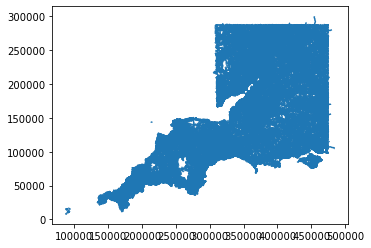

In [15]:
roads.plot()